In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [34]:
img = 'IMGP0107.jpg'

img1 = Image.open(img)
img1 = np.array(img1)
img1.shape

(4128, 6192, 3)

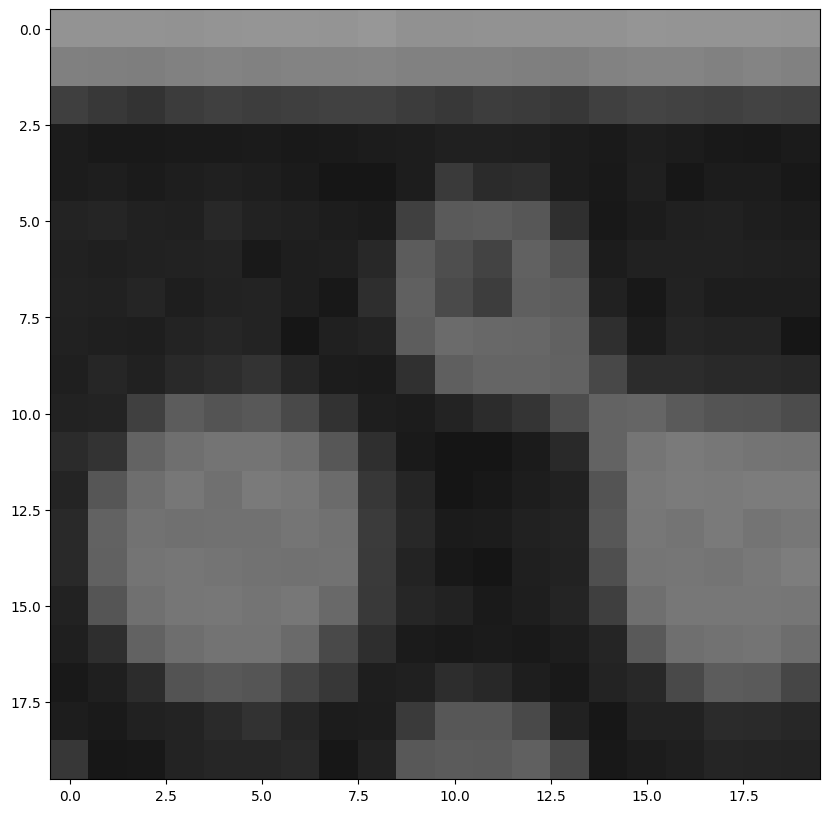

In [35]:
a = img1[2650:2670, 2650:2670]

# Image.fromarray(a).save('lr.png')

plt.figure(figsize=(10,10))
plt.imshow(a)
plt.show()

In [36]:
im = 'IMGP0119.jpg'

img2 = Image.open(im)
img2 = np.array(img2)
img2.shape

(4128, 6192, 3)

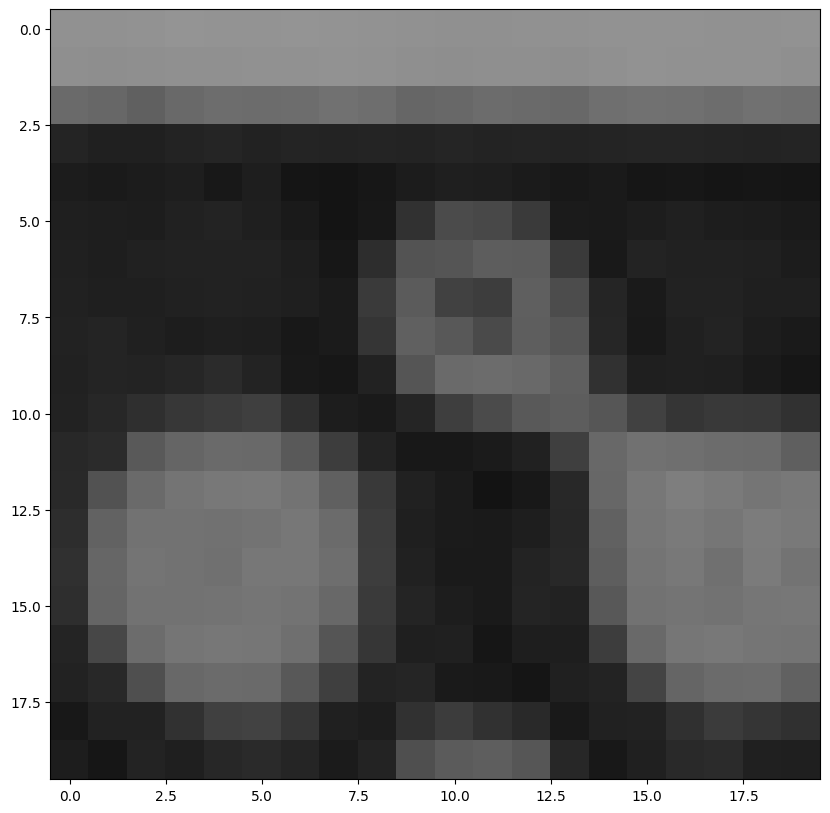

In [37]:
b = img2[2650:2670, 2650:2670]
plt.figure(figsize=(10,10))
plt.imshow(b)
plt.show()

In [24]:
imag = 'IMGP0108.jpg'

img3 = Image.open(imag)
img3 = np.array(img3)
img3.shape

(4128, 6192, 3)

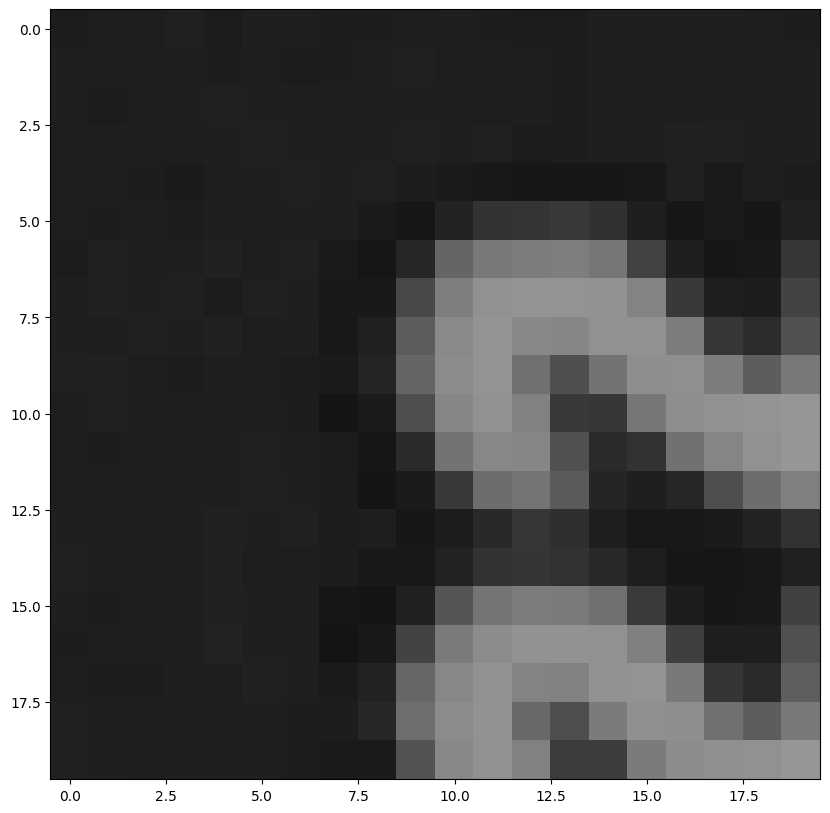

In [25]:
c = img3[2650:2670, 2550:2570]
plt.figure(figsize=(10,10))
plt.imshow(c)
plt.show()

In [26]:
image = 'IMGP0130.jpg'

img4 = Image.open(image)
img4 = np.array(img4)
img4.shape

(4128, 6192, 3)

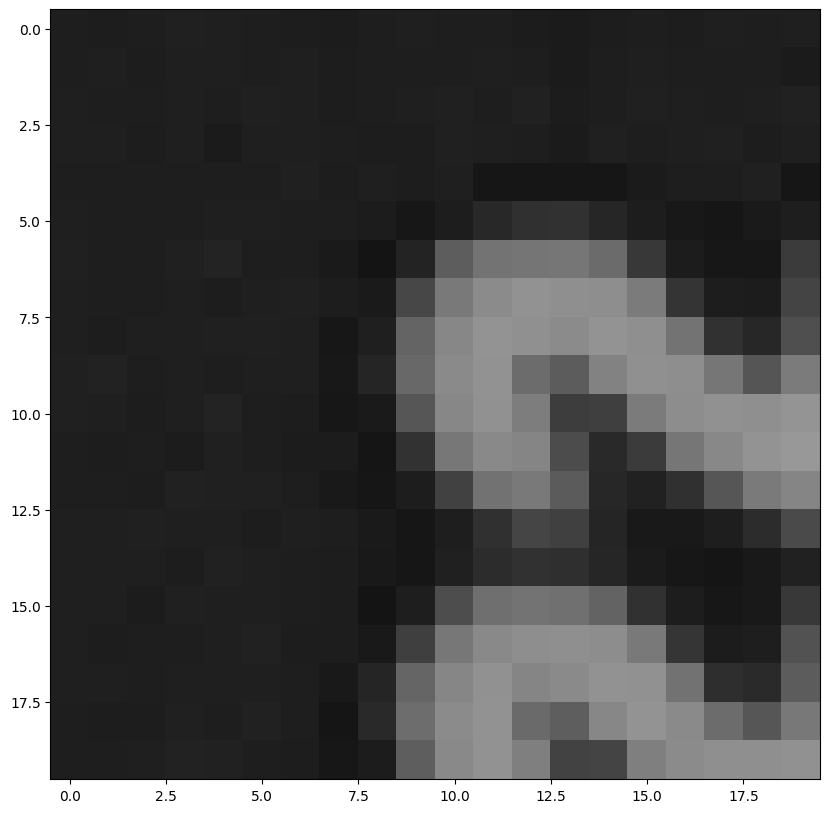

In [27]:
d = img4[2650:2670, 2550:2570]
plt.figure(figsize=(10,10))
plt.imshow(d)
plt.show()

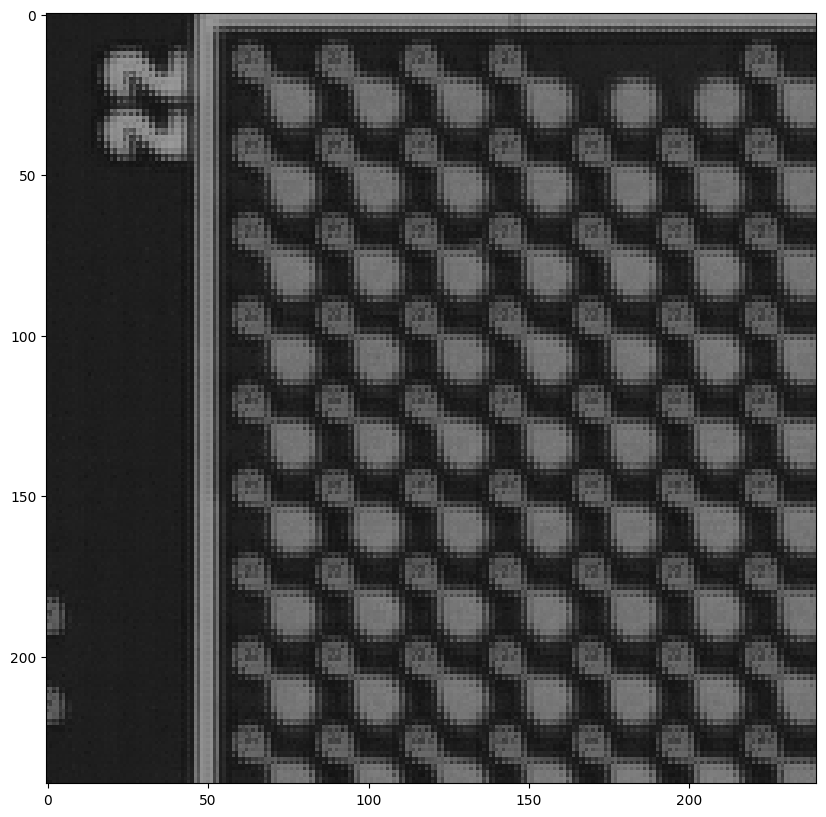

In [11]:
import copy 
H, W, C = 120, 120, 3

# Create high-resolution grid
HR = np.zeros((2 * H, 2 * W, C), dtype=np.float32)
weight = np.zeros((2 * H, 2 * W, 1), dtype=np.float32)

# Helper to place pixels
def accumulate(img, dy, dx):
    """
    dy, dx in sub-pixel units:
    (0,0)   -> (0,0)
    (0,-0.5)-> (1,0)
    (-0.5,0)-> (0,1)
    """
    y_offset = int(round(dy * 2))
    x_offset = int(round(dx * 2))

    HR[y_offset::2, x_offset::2, :] += img
    weight[y_offset::2, x_offset::2, :] += 1

# Reference image
accumulate(a, dy=0.0, dx=0.0)

# Shifted up (half pixel)
accumulate(b, dy=0.5, dx=0.0)

# Shifted left (half pixel)
accumulate(c, dy=0.0, dx=0.5)

# Shifted left (half pixel)
accumulate(d, dy=0.5, dx=0.5)

temp = copy.deepcopy(weight)
# Avoid division by zero
weight[weight == 0] = 1.0

HR /= weight

HR = np.clip(HR, 0, 255).astype(np.uint8)

# HR = cv2.inpaint(
#     HR,
#     (temp.squeeze() == 0).astype(np.uint8),
#     inpaintRadius=1,
#     flags=cv2.INPAINT_TELEA
# )

# HR = cv2.fastNlMeansDenoisingColored(HR, None, 3, 3, 7, 21)

plt.figure(figsize=(10,10))
plt.imshow(HR)
plt.show()

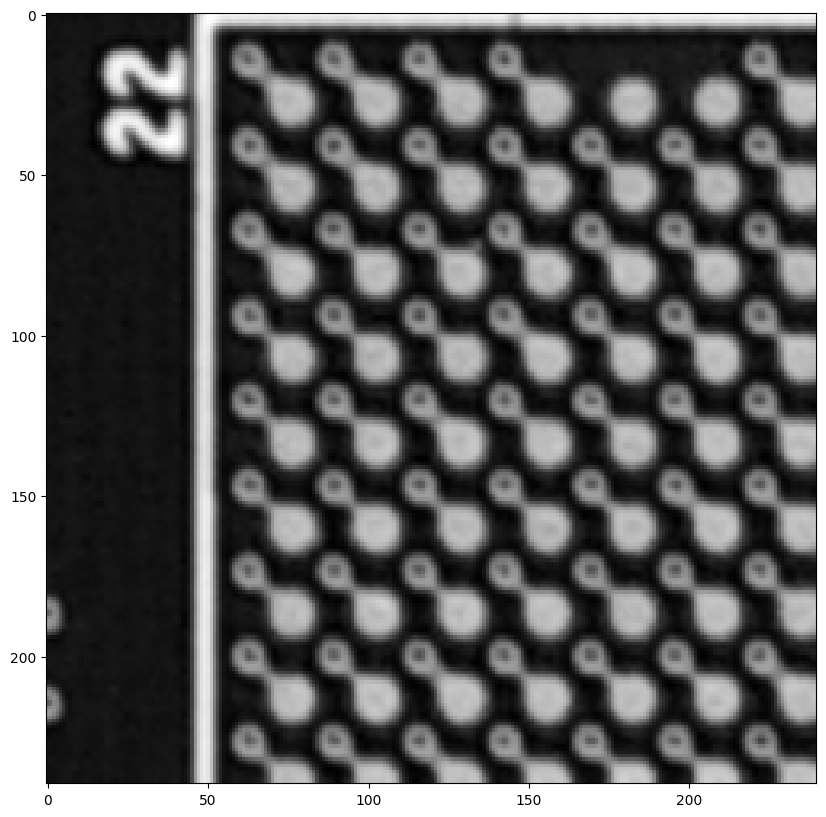

In [12]:
e = cv2.resize(a, (240, 240), cv2.INTER_NEAREST)
plt.figure(figsize=(10,10))
plt.imshow(e[:,:,0], cmap='gray')
plt.show()

In [13]:
shift, _ = cv2.phaseCorrelate(
    a[:,:,0].astype(np.float32),
    d[:,:,0].astype(np.float32)
)
print(shift)

(0.5846370930499702, 0.2674425629952921)


In [14]:
def shift_and_add(images, shifts):
    H, W, C = images[0].shape
    HR = np.zeros((2*H, 2*W, C), np.float32)
    Wt = np.zeros((2*H, 2*W, 1), np.float32)

    for img, (dx, dy) in zip(images, shifts):
        up = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        M = np.float32([[1, 0, dx*2], [0, 1, dy*2]])
        shifted = cv2.warpAffine(up, M, (2*W, 2*H))

        HR += shifted
        Wt += (shifted.sum(axis=2, keepdims=True) > 0)

    HR /= np.maximum(Wt, 1)
    return HR.astype(np.uint8)

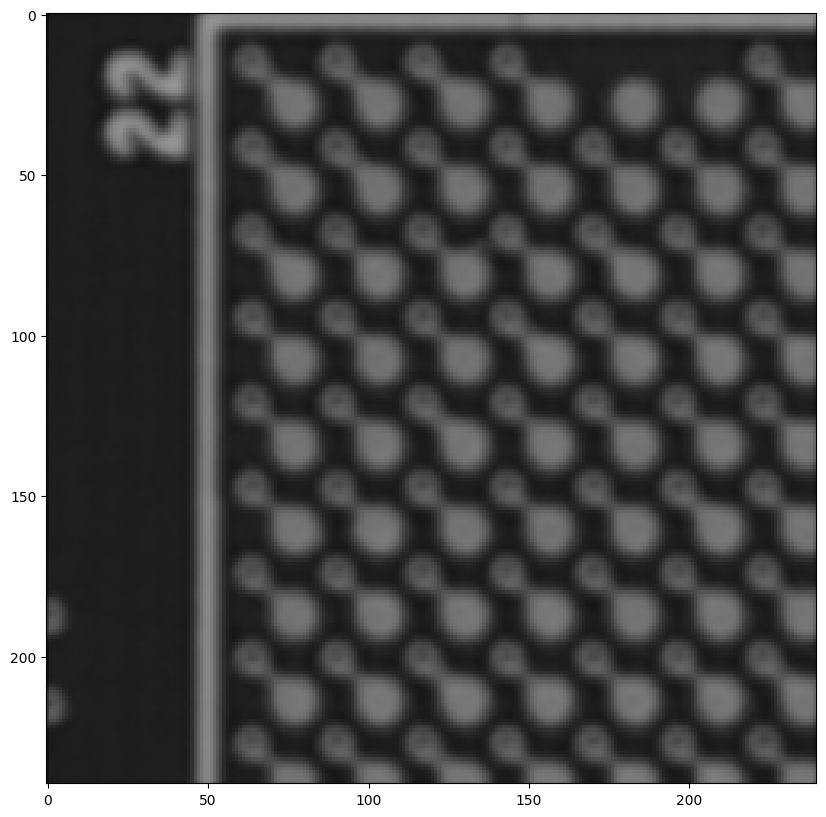

In [15]:
q = shift_and_add([a, b, c, d], [(0.,0.), (-0.2034085508759933, 0.5759448957845752), (0.5390787813801232, -0.07517001720000493), (0.46549099515756076, 0.1484953109191629)])

plt.figure(figsize=(10,10))
plt.imshow(q, cmap='gray')
plt.show()

Registering images (measuring random shifts)...
Image 1 Shift: x=-0.1598, y=0.5506
Image 2 Shift: x=0.4014, y=-0.0117
Image 3 Shift: x=0.3898, y=0.1347
Accumulating/Splatting pixels...


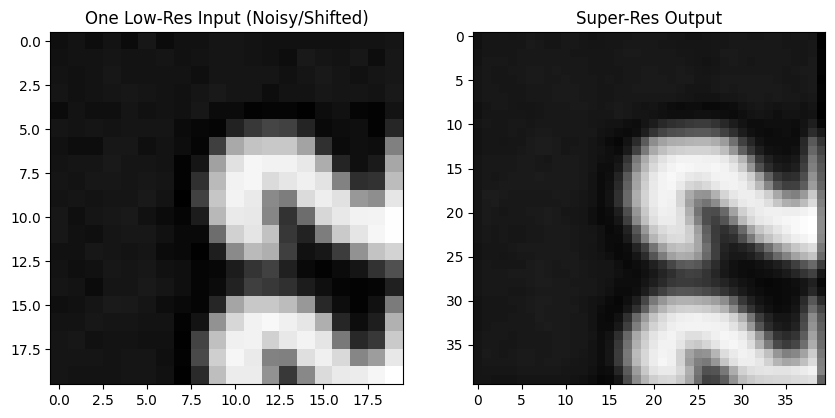

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def register_images(ref_img, images):
    """
    Aligns all images to the reference image using ECC algorithm 
    to find sub-pixel shifts (motion).
    """
    aligned_images = []
    homographies = []
    
    # Define the motion model (Translation only for this example, 
    # but EUCLIDEAN allows rotation too)
    warp_mode = cv2.MOTION_TRANSLATION
    
    # Terminate the optimizer if it runs 50 iterations or error is small
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 1e-10)

    print("Registering images (measuring random shifts)...")
    for i, img in enumerate(images):
        if i == 0:
            # The first image is our anchor; no shift.
            aligned_images.append(img)
            homographies.append(np.eye(2, 3, dtype=np.float32))
            continue
            
        # Initialize the warp matrix
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        
        # Run the ECC algorithm (Maximizes correlation between images)
        try:
            (cc, warp_matrix) = cv2.findTransformECC(
                ref_img, img, warp_matrix, warp_mode, criteria
            )
            
            # Store the matrix (this contains the random float shift x/y)
            homographies.append(warp_matrix)
            print(f"Image {i} Shift: x={warp_matrix[0,2]:.4f}, y={warp_matrix[1,2]:.4f}")
            
            # We don't warp the image here yet; we need the raw pixels for Super Res.
            aligned_images.append(img)
            
        except cv2.error:
            print(f"Warning: Could not register image {i}")

    return aligned_images, homographies

def super_resolve_random_shifts(images, homographies, scale=2):
    """
    Reconstructs High-Res image using Weighted Accumulation (Splatting).
    """
    h, w = images[0].shape
    hr_h, hr_w = h * scale, w * scale
    
    # 1. Accumulation Buffers (High Precision)
    # Numerator: Stores sum of weighted pixel values
    accumulator = np.zeros((hr_h, hr_w), dtype=np.float32)
    # Denominator: Stores sum of weights (to normalize later)
    divisor = np.zeros((hr_h, hr_w), dtype=np.float32)
    
    print("Accumulating/Splatting pixels...")
    
    for idx, img in enumerate(images):
        # Get the shift for this image
        M = homographies[idx]
        shift_x = M[0, 2]
        shift_y = M[1, 2]
        
        # 2. Scale the shift to the High-Res domain
        # If image shifted 0.5 px in Low-Res, it shifts 1.0 px in High-Res (2x)
        M_hr = np.array([
            [1, 0, shift_x * scale],
            [0, 1, shift_y * scale]
        ], dtype=np.float32)
        
        # 3. Upscale the Low-Res image to High-Res size (Nearest Neighbor)
        # We want the distinct pixels, not pre-blurred bilinear ones.
        img_hr_view = cv2.resize(img, (hr_w, hr_h), interpolation=cv2.INTER_NEAREST)
        
        # 4. Warp the image to align with the reference
        # We use WarpAffineInverse to pull the pixels to the correct grid location
        aligned_img = cv2.warpAffine(
            img_hr_view, M_hr, (hr_w, hr_h), 
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
            borderMode=cv2.BORDER_CONSTANT, 
            borderValue=0
        )
        
        # 5. Create a Weight Mask (Binary or Gaussian)
        # Simple version: All valid pixels get weight 1
        mask = (aligned_img > 0).astype(np.float32)
        
        # Add to accumulators
        accumulator += aligned_img
        divisor += mask

    # 6. Normalize (Average)
    # Avoid division by zero
    divisor[divisor == 0] = 1 
    sr_image = accumulator / divisor
    
    return np.clip(sr_image, 0, 255).astype(np.uint8)

# --- EXECUTION EXAMPLE ---

# 1. Generate Dummy Random Data
# We create a base image and shift it randomly using warpAffine
base = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(base, (20, 20), (80, 80), 255, -1)
cv2.circle(base, (50, 50), 10, 0, -1) # A hole to see detail

random_inputs = []
# Create 10 random frames
np.random.seed(42)
for i in range(10):
    # Random shift between -2 and +2 pixels
    tx = np.random.uniform(-2, 2)
    ty = np.random.uniform(-2, 2)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    shifted = cv2.warpAffine(base, M, (100, 100))
    # Add noise to make it realistic
    noise = np.random.normal(0, 5, shifted.shape).astype(np.uint8)
    random_inputs.append(cv2.add(shifted, noise))

# 2. Register (Measure) the shifts automatically
# Note: We pass the first image as the reference
aligned_imgs, computed_homographies = register_images(a[:,:,0], [a[:,:,0], b[:,:,0], c[:,:,0], d[:,:,0]])

# 3. Super Resolve
sr_final = super_resolve_random_shifts([a[:,:,0], b[:,:,0], c[:,:,0], d[:,:,0]], computed_homographies, scale=2)

# 4. Show
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("One Low-Res Input (Noisy/Shifted)"); plt.imshow(a[:,:,0], cmap='gray')
plt.subplot(1,2,2); plt.title("Super-Res Output"); plt.imshow(sr_final, cmap='gray')
plt.show()

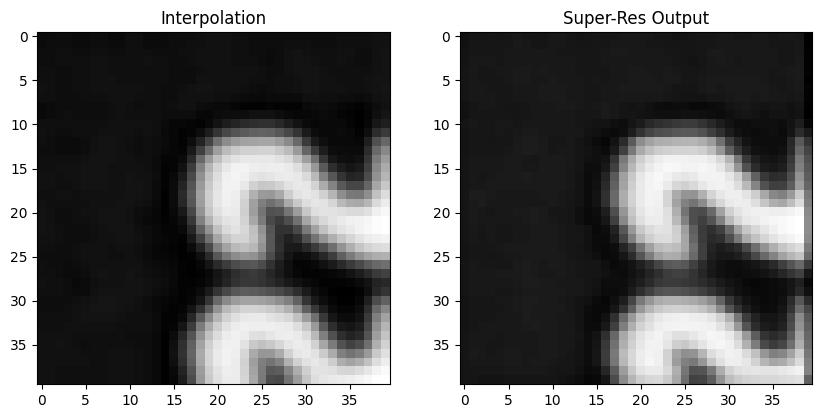

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Interpolation"); plt.imshow(cv2.resize(a[:,:,0], (40, 40)), cmap='gray')
plt.subplot(1,2,2); plt.title("Super-Res Output"); plt.imshow(sr_final, cmap='gray')
plt.show()

In [156]:
Image.fromarray(cv2.resize(a, (40,40))).save('int.png')